In [29]:
import pandas as pd
import numpy as np
from itertools import product

# URLs
base = "https://raw.githubusercontent.com/opencampus-sh/einfuehrung-in-data-science-und-ml/main/"
df_umsatz = pd.read_csv(base + "umsatzdaten_gekuerzt.csv")
df_wetter = pd.read_csv(base + "wetter.csv")
df_kiwo = pd.read_csv(base + "kiwo.csv")

# Datum vereinheitlichen
for df in [df_umsatz, df_wetter, df_kiwo]:
    df["Datum"] = pd.to_datetime(df["Datum"])

# KiWo binär markieren
df_kiwo["KiWo"] = 1

# Vollständige Datum-Warengruppe-Kombination
alle_daten = pd.date_range(start="2013-07-01", end="2019-07-31", freq="D")
warengruppen = [1, 2, 3, 4, 5, 6]
voll_kombis = pd.DataFrame(list(product(alle_daten, warengruppen)), columns=["Datum", "Warengruppe"])

# Merge Wetter nur auf Datum (jeder Tag bekommt Wetterdaten)
df = voll_kombis.merge(df_wetter, on="Datum", how="left")

# Merge KiWo auf Datum (KiWo für jeden Tag)
df = df.merge(df_kiwo[["Datum", "KiWo"]], on="Datum", how="left")
df["KiWo"] = df["KiWo"].fillna(0).astype(int)

# Merge Umsatz auf Datum+Warengruppe (Umsatz nur, wenn vorhanden)
df = df.merge(df_umsatz, on=["Datum", "Warengruppe"], how="left")

# Umsatz NaNs mit 0 ersetzen (kein Umsatz für diese Warengruppe am Tag)
df["Umsatz"] = df["Umsatz"].fillna(0)

# Optional: Wetter-NaNs auffüllen (hier Beispiel Forward Fill)
df = df.sort_values("Datum")
df.fillna(method="ffill", inplace=True)
df.fillna(method="bfill", inplace=True)

# ID generieren (YYMMDDX)
df["id"] = df.apply(lambda row: int(row["Datum"].strftime("%y%m%d") + str(row["Warengruppe"])), axis=1)

# Zeitliche Splits
train_mask = (df["Datum"] >= "2013-07-01") & (df["Datum"] <= "2017-07-31")
val_mask   = (df["Datum"] >= "2017-08-01") & (df["Datum"] <= "2018-07-31")
test_mask  = (df["Datum"] >= "2018-08-01") & (df["Datum"] <= "2019-07-31")

df_train = df[train_mask].copy()
df_val   = df[val_mask].copy()
df_test  = df[test_mask].copy()

# Sortierung
df_train = df_train.sort_values(by=["Warengruppe", "Datum"]).reset_index(drop=True)
df_val   = df_val.sort_values(by=["Warengruppe", "Datum"]).reset_index(drop=True)
df_test  = df_test.sort_values(by=["Warengruppe", "Datum"]).reset_index(drop=True)


#Begrenzung: Nur Warengruppe 6 auf 01.11.2018 bis 28.12.2018
df_test = df_test[
    ~((df_test["Warengruppe"] == 6) & (
        (df_test["Datum"] < "2018-11-01") | (df_test["Datum"] > "2018-12-28")
    ))
].copy()


# Submission vorbereiten
df_submission = df_test[["id"]].copy()
df_submission["Umsatz"] = 0

# Kontrolle
print("Train:", df_train.shape)
print("Val:", df_val.shape)
print("Test:", df_test.shape)
print("\nNaNs in Train:\n", df_train.isna().sum())
print("\nNaNs in Val:\n", df_val.isna().sum())
print("\nNaNs in Test:\n", df_test.isna().sum())


Train: (8952, 9)
Val: (2190, 9)
Test: (1883, 9)

NaNs in Train:
 Datum                  0
Warengruppe            0
Bewoelkung             0
Temperatur             0
Windgeschwindigkeit    0
Wettercode             0
KiWo                   0
id                     0
Umsatz                 0
dtype: int64

NaNs in Val:
 Datum                  0
Warengruppe            0
Bewoelkung             0
Temperatur             0
Windgeschwindigkeit    0
Wettercode             0
KiWo                   0
id                     0
Umsatz                 0
dtype: int64

NaNs in Test:
 Datum                  0
Warengruppe            0
Bewoelkung             0
Temperatur             0
Windgeschwindigkeit    0
Wettercode             0
KiWo                   0
id                     0
Umsatz                 0
dtype: int64


/tmp/ipykernel_2168/3665443335.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="ffill", inplace=True)
/tmp/ipykernel_2168/3665443335.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)


In [30]:
# Kontrolle
print("Train:", df_train.shape)
print("Val  :", df_val.shape)
print("Test :", df_test.shape)
print("\nBeispiel Submission:\n", df_submission.head())

Train: (8952, 9)
Val  : (2190, 9)
Test : (1883, 9)

Beispiel Submission:
         id  Umsatz
0  1808011       0
1  1808021       0
2  1808031       0
3  1808041       0
4  1808051       0


In [31]:
# Head und Tail von Train, Validation und Test anzeigen
print("📘 TRAIN SET")
print("HEAD:")
display(df_train.head())
print("\nTAIL:")
display(df_train.tail())

print("\n📙 VALIDATION SET")
print("HEAD:")
display(df_val.head())
print("\nTAIL:")
display(df_val.tail())

print("\n📕 TEST SET")
print("HEAD:")
display(df_test.head())
print("\nTAIL:")
display(df_test.tail())


📘 TRAIN SET
HEAD:


,Datum,Warengruppe,Bewoelkung,Temperatur,Windgeschwindigkeit,Wettercode,KiWo,id,Umsatz
0,2013-07-01,1,6.0,17.8375,15.0,20.0,0,1307011,148.828353
1,2013-07-02,1,3.0,17.3125,10.0,20.0,0,1307021,159.793757
2,2013-07-03,1,7.0,21.0750,6.0,61.0,0,1307031,111.885594
3,2013-07-04,1,7.0,18.8500,7.0,20.0,0,1307041,168.864941
4,2013-07-05,1,5.0,19.9750,12.0,20.0,0,1307051,171.280754



TAIL:


,Datum,Warengruppe,Bewoelkung,Temperatur,Windgeschwindigkeit,Wettercode,KiWo,id,Umsatz
8947,2017-07-27,6,6.0,19.500,10.0,61.0,0,1707276,0.0
8948,2017-07-28,6,6.0,18.125,17.0,61.0,0,1707286,0.0
8949,2017-07-29,6,5.0,19.625,11.0,61.0,0,1707296,0.0
8950,2017-07-30,6,5.0,24.000,11.0,61.0,0,1707306,0.0
8951,2017-07-31,6,2.0,22.750,9.0,61.0,0,1707316,0.0



📙 VALIDATION SET
HEAD:


,Datum,Warengruppe,Bewoelkung,Temperatur,Windgeschwindigkeit,Wettercode,KiWo,id,Umsatz
0,2017-08-01,1,6.0,21.375,7.0,21.0,0,1708011,166.135486
1,2017-08-02,1,5.0,21.375,8.0,61.0,0,1708021,155.022099
2,2017-08-03,1,7.0,20.125,10.0,95.0,0,1708031,159.575340
3,2017-08-04,1,6.0,19.625,18.0,21.0,0,1708041,161.585239
4,2017-08-05,1,4.0,20.125,12.0,21.0,0,1708051,198.088094



TAIL:


,Datum,Warengruppe,Bewoelkung,Temperatur,Windgeschwindigkeit,Wettercode,KiWo,id,Umsatz
2185,2018-07-27,6,0.0,27.5875,16.0,5.0,0,1807276,0.0
2186,2018-07-28,6,3.0,28.7500,11.0,95.0,0,1807286,0.0
2187,2018-07-29,6,0.0,24.5500,6.0,95.0,0,1807296,0.0
2188,2018-07-30,6,6.0,27.7875,10.0,21.0,0,1807306,0.0
2189,2018-07-31,6,5.0,31.2875,11.0,21.0,0,1807316,0.0



📕 TEST SET
HEAD:


,Datum,Warengruppe,Bewoelkung,Temperatur,Windgeschwindigkeit,Wettercode,KiWo,id,Umsatz
0,2018-08-01,1,0.0,23.7625,10.0,0.0,0,1808011,0.0
1,2018-08-02,1,0.0,26.1875,10.0,0.0,0,1808021,0.0
2,2018-08-03,1,1.0,27.6625,10.0,0.0,0,1808031,0.0
3,2018-08-04,1,4.0,25.1375,12.0,0.0,0,1808041,0.0
4,2018-08-05,1,7.0,21.3000,14.0,61.0,0,1808051,0.0



TAIL:


,Datum,Warengruppe,Bewoelkung,Temperatur,Windgeschwindigkeit,Wettercode,KiWo,id,Umsatz
1970,2018-12-24,6,7.0,2.5000,10.0,22.0,0,1812246,0.0
1971,2018-12-25,6,7.0,6.3625,16.0,22.0,0,1812256,0.0
1972,2018-12-26,6,7.0,7.9125,12.0,0.0,0,1812266,0.0
1973,2018-12-27,6,7.0,7.1250,12.0,20.0,0,1812276,0.0
1974,2018-12-28,6,7.0,7.3125,11.0,61.0,0,1812286,0.0


 Linear Regression Model

 Step 1: Zielvariable = Umsatz (dependent variable, Y)
 (already in df_train, df_val, df_test)

 Step 2: find independent variable X

Korrelation mit Umsatz:
 Umsatz                 1.000000
Temperatur             0.152721
KiWo                   0.039523
Wettercode             0.006562
Windgeschwindigkeit   -0.002146
Bewoelkung            -0.066510
Warengruppe           -0.313397
Name: Umsatz, dtype: float64


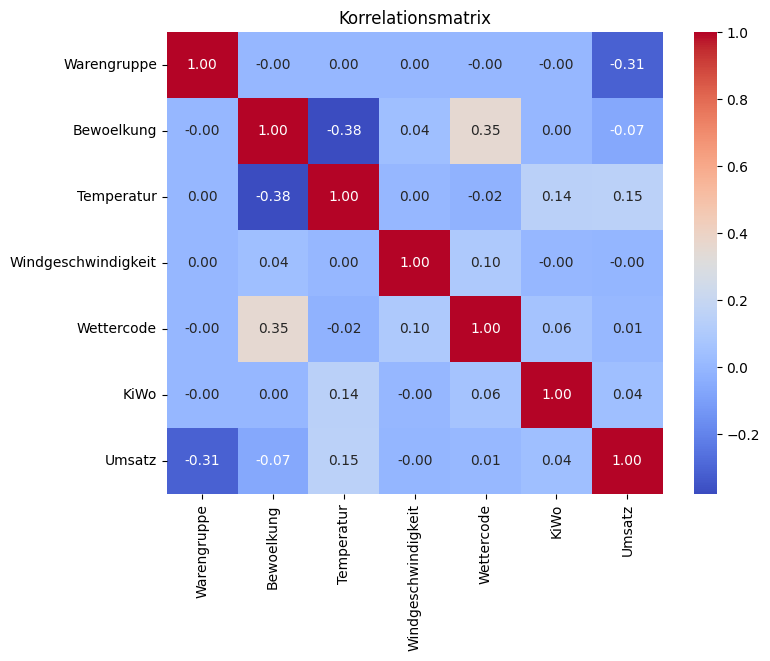

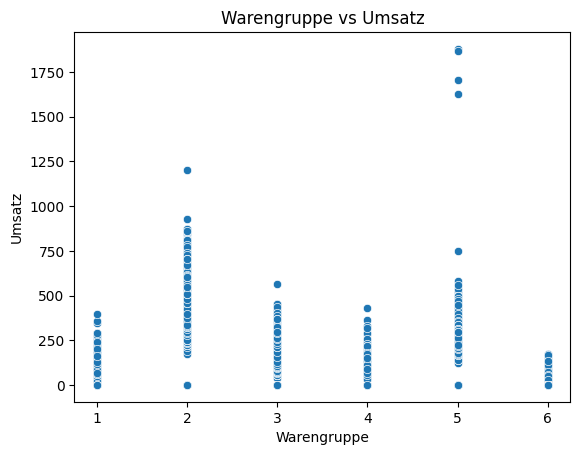

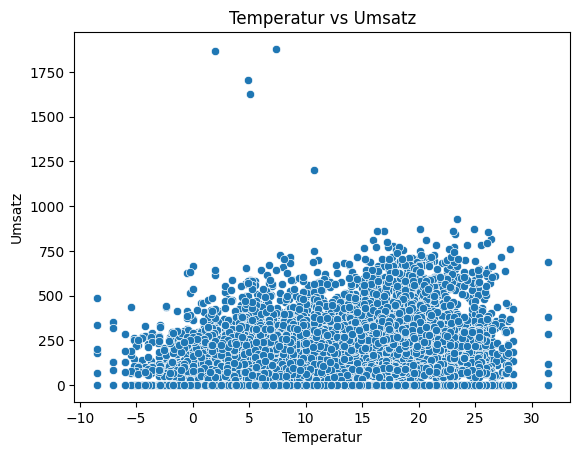

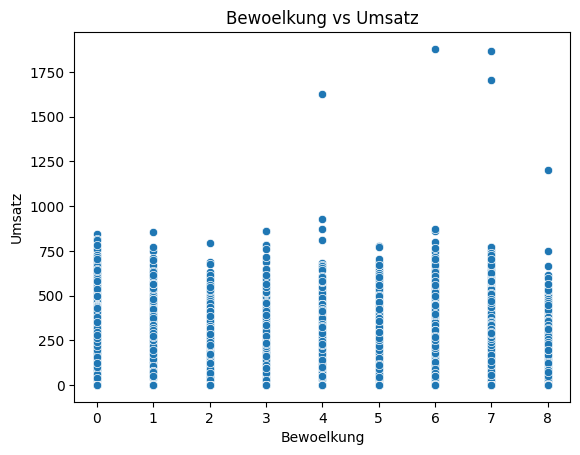

In [32]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm


#from sklearn.linear_model import LinearRegression
#from sklearn.metrics import mean_squared_error
#from sklearn.preprocessing import StandardScaler


#  Korrelation untersuchen
numeric_features = df_train.select_dtypes(include=["number"]).drop(columns=["id", "Umsatz"])
correlations = df_train[numeric_features.columns.tolist() + ["Umsatz"]].corr()
print("Korrelation mit Umsatz:\n", correlations["Umsatz"].sort_values(ascending=False))

# Optional: Visualisieren
plt.figure(figsize=(8, 6))
sns.heatmap(correlations, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Korrelationsmatrix")
plt.show()

#  Scatterplots für einzelne Features
top_features = correlations["Umsatz"].drop("Umsatz").abs().sort_values(ascending=False).head(3).index.tolist()
for feature in top_features:
    sns.scatterplot(data=df_train, x=feature, y="Umsatz")
    plt.title(f"{feature} vs Umsatz")
    plt.show()

Indenpendent variable : Temperature

In [33]:


# Nur Temperatur verwenden
X_train = df_train[["Temperatur"]]
y_train = df_train["Umsatz"]

# Intercept hinzufügen (statsmodels verlangt expliziten konstanten Term)
X_train = sm.add_constant(X_train)

# Modell trainieren (OLS = Ordinary Least Squares)
model = sm.OLS(y_train, X_train)
results = model.fit()

# Zusammenfassung anzeigen
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:                 Umsatz   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     213.7
Date:                Thu, 05 Jun 2025   Prob (F-statistic):           7.49e-48
Time:                        09:33:26   Log-Likelihood:                -57788.
No. Observations:                8952   AIC:                         1.156e+05
Df Residuals:                    8950   BIC:                         1.156e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        133.9302      3.259     41.091      0.0

In [34]:
# Testdaten vorbereiten
X_test = df_test[["Temperatur"]]
X_test = sm.add_constant(X_test)

# Prognose erstellen
test_pred = results.predict(X_test)

# In Submission speichern
df_submission["Umsatz"] = test_pred
df_submission.to_csv("submission_statsmodels_temp.csv", index=False)
print("✅ submission_statsmodels_temp.csv gespeichert.")


✅ submission_statsmodels_temp.csv gespeichert.


In [35]:
# One-Hot-Encoding von Warengruppe, Drop First verhindert Multikollinearität
X_train = pd.get_dummies(df_train[["Temperatur", "KiWo", "Warengruppe"]], 
                         columns=["Warengruppe"], drop_first=True)
X_train = X_train.astype(float)
print(X_train.dtypes)
X_train = X_train.astype(float)

# Intercept hinzufügen
X_train = sm.add_constant(X_train)

# Zielvariable
y_train = df_train["Umsatz"]

# Modell trainieren
model = sm.OLS(y_train, X_train)
results = model.fit()

# Zusammenfassung anzeigen
print(results.summary())


Temperatur       float64
KiWo             float64
Warengruppe_2    float64
Warengruppe_3    float64
Warengruppe_4    float64
Warengruppe_5    float64
Warengruppe_6    float64
dtype: object
                            OLS Regression Results                            
Dep. Variable:                 Umsatz   R-squared:                       0.714
Model:                            OLS   Adj. R-squared:                  0.714
Method:                 Least Squares   F-statistic:                     3194.
Date:                Thu, 05 Jun 2025   Prob (F-statistic):               0.00
Time:                        09:33:26   Log-Likelihood:                -52286.
No. Observations:                8952   AIC:                         1.046e+05
Df Residuals:                    8944   BIC:                         1.046e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                    c

 This script compares two CSV files: 'sample_submission.csv(the template)
 and 'your_submission.csv' (your generated file). It checks which IDs are
 missing in your file and which ones are extra, based on the 'id' column.

In [36]:
# Load the two CSV files

sample_df = pd.read_csv("/workspaces/ml_codespace_team4_opencampus/data/sample_submission.csv")

your_df = pd.read_csv('submission_statsmodels_temp.csv')

# Extract the ID columns (assuming the column is named "id")
sample_ids = set(sample_df['id'])
your_ids = set(your_df['id'])

# Find IDs that are missing in your file and IDs that are extra
missing_in_your_file = sample_ids - your_ids      # Present in sample, missing in yours
extra_in_your_file = your_ids - sample_ids        # Present in yours, not in sample

# Print the results
print("IDs missing in your submission (should be there):")
print(missing_in_your_file)

print("\nIDs that are extra in your submission (should not be there):")
print(extra_in_your_file)

IDs missing in your submission (should be there):
set()

IDs that are extra in your submission (should not be there):
{1810311, 1810312, 1810313, 1810314, 1810315, 1812251, 1812252, 1812253, 1812254, 1812255, 1812256, 1904031, 1904032, 1904033, 1904034, 1812261, 1812262, 1812263, 1812264, 1812265, 1812266, 1904035, 1904191, 1904192, 1904193, 1904194, 1904195, 1901011, 1901012, 1901013, 1901014, 1901015, 1812314, 1907101, 1903201, 1903202, 1903203, 1903204, 1903205, 1907102, 1907103, 1907104, 1907311, 1907312, 1907313, 1907314, 1905011, 1905012, 1905013, 1905014, 1905015, 1907105, 1907315}
